In [1]:
# Load packages and directories


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.subplots as sp
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import tslearn.clustering as tsc

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import sklearn.preprocessing as pr
import sklearn.metrics as mt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize, Normalizer

from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from tslearn.barycenters import softdtw_barycenter 
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances_argmin_min
from sklearn_extra.cluster import KMedoids 
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram, linkage,  single, complete, average, ward, fcluster
from tslearn.metrics import dtw, cdist_dtw
import importlib
import clustering_processing2, preprocessing, cluster_grid

base_directory = "C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning"
data_directory = os.path.join(base_directory, 'edp_data')
cleaned_data_directory = os.path.join(base_directory, 'resampled_30min_data')

# Directory containing the household profile CSV files
survey_data = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_aircon.csv'))  
output_directory = os.path.join(base_directory, 'figures')  # Change this to your output directory

climate_zone_descriptions = {
    1: 'High humidity summer, warm winter (Zone 1)',
    2: 'Warm humid summer, mild winter (Zone 2)',
    3: 'Hot dry summer, warm winter (Zone 3)',
    4: 'Hot dry summer, cool winter (Zone 4)',
    5: 'Warm temperate (Zone 5)',
    6: 'Mild temperate (Zone 6)',
    7: 'Cool temperate (Zone 7)',
    8: 'Alpine (Zone 8)'
}

survey_data['climate_zone'] = survey_data['climate_zone'].map(climate_zone_descriptions)

In [2]:
importlib.reload(preprocessing)
from preprocessing import create_combined_df

# create combined_df
# Directory containing the household CSV files
data_dir = cleaned_data_directory

# Create a complete date range for 2023 in 30-minute increments
date_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:30:00', freq='30T')

combined_df = create_combined_df(cleaned_data_directory, date_range)
# Define the path for the CSV file
csv_path = os.path.join(base_directory, 'combined_aircon_profiles.csv')

# # Write to CSV only if the file doesn't already exist
if not os.path.exists(csv_path):
    combined_df.to_csv(csv_path, index=False)
    print(f'File written: {csv_path}')
else:
    print('File already exists!')



File already exists!


In [ ]:
importlib.reload(preprocessing)
preprocessing.visualize_max_half_hourly_consumption(combined_df)

In [3]:
importlib.reload(preprocessing)
min_cons = 0.015 # pick a number to group low consumption values together, guessing using 10kW air conditioning unit and 50 W standby power consumption
fluctu_ratio = 1.2 # pick a number to group low consumption values together
low_consumption_dict = preprocessing.create_low_consumption_with_ratio_dict(combined_df, max_threshold=min_cons, fluctuation_ratio_threshold=fluctu_ratio)

In [4]:
print(low_consumption_dict)

{datetime.date(2023, 1, 1): ['S0225', 'S0238', 'S0250', 'S0318', 'S0339', 'S0349', 'S0353', 'S0387', 'S0462', 'S0495', 'S0548', 'W0004', 'W0008', 'W0013', 'W0016', 'W0029', 'W0035', 'W0051', 'W0058', 'W0062', 'W0068', 'W0089', 'W0094', 'W0143', 'W0145', 'W0178', 'W0182', 'W0193', 'W0195', 'W0221', 'W0233', 'W0275', 'W0278', 'W0291', 'W0303', 'W0322', 'W0329'], datetime.date(2023, 1, 2): ['S0110', 'S0225', 'S0238', 'S0250', 'S0291', 'S0339', 'S0353', 'S0387', 'S0392', 'S0462', 'S0470', 'W0004', 'W0008', 'W0013', 'W0029', 'W0035', 'W0051', 'W0058', 'W0062', 'W0143', 'W0145', 'W0193', 'W0195', 'W0221', 'W0275', 'W0278', 'W0299', 'W0334'], datetime.date(2023, 1, 3): ['S0225', 'S0250', 'S0291', 'S0339', 'S0353', 'S0392', 'S0407', 'S0462', 'S0470', 'S0509', 'W0002', 'W0004', 'W0008', 'W0013', 'W0014', 'W0016', 'W0017', 'W0035', 'W0039', 'W0040', 'W0051', 'W0057', 'W0058', 'W0061', 'W0062', 'W0068', 'W0088', 'W0089', 'W0094', 'W0107', 'W0145', 'W0161', 'W0178', 'W0188', 'W0193', 'W0195', 'W02

In [27]:
importlib.reload(cluster_grid)
start_date = '2023-01-01'
end_date = '2023-12-31'
num_clusters = 9
min_cluster_size = None
max_cluster_size = None

# Example usage
rlp_dict, cluster_sites_df, metrics_df = cluster_grid.process_multiple_days(
    df=combined_df,  # Your pre-scaled data
    start_date=start_date,
    end_date=end_date,
    num_clusters=num_clusters,
    low_consumption_sites_dict=low_consumption_dict,
    min_cluster_size=min_cluster_size,  # Optional
    max_cluster_size=max_cluster_size,  # Optional
    feature_weights={  # Optional
        'raw_profile': 0.7,
        'summary_stats': 0.3
    }
)


In [28]:
importlib.reload(cluster_grid)

start_date = '2023-01-01'
end_date = '2023-12-31'
num_clusters = 9
#rlp_dict, cluster_sites_df, metrics_df2 = cluster_grid.create_cluster_grid_rep_LP_constrained(combined_df, start_date, end_date, num_clusters, low_consumption_dict, min_cluster_size = None, max_cluster_size=60)        
#rlp_dict, cluster_sites_df, metrics_df3 = cluster_grid.create_cluster_grid_rep_LP_constrained(combined_df, start_date, end_date, num_clusters, low_consumption_dict, min_cluster_size = None, max_cluster_size=70)        
rlp_dict, cluster_sites_df, metrics_df = cluster_grid.create_cluster_grid_rep_LP_constrained(combined_df, start_date, end_date, num_clusters, low_consumption_dict, min_cluster_size = None, max_cluster_size=None)


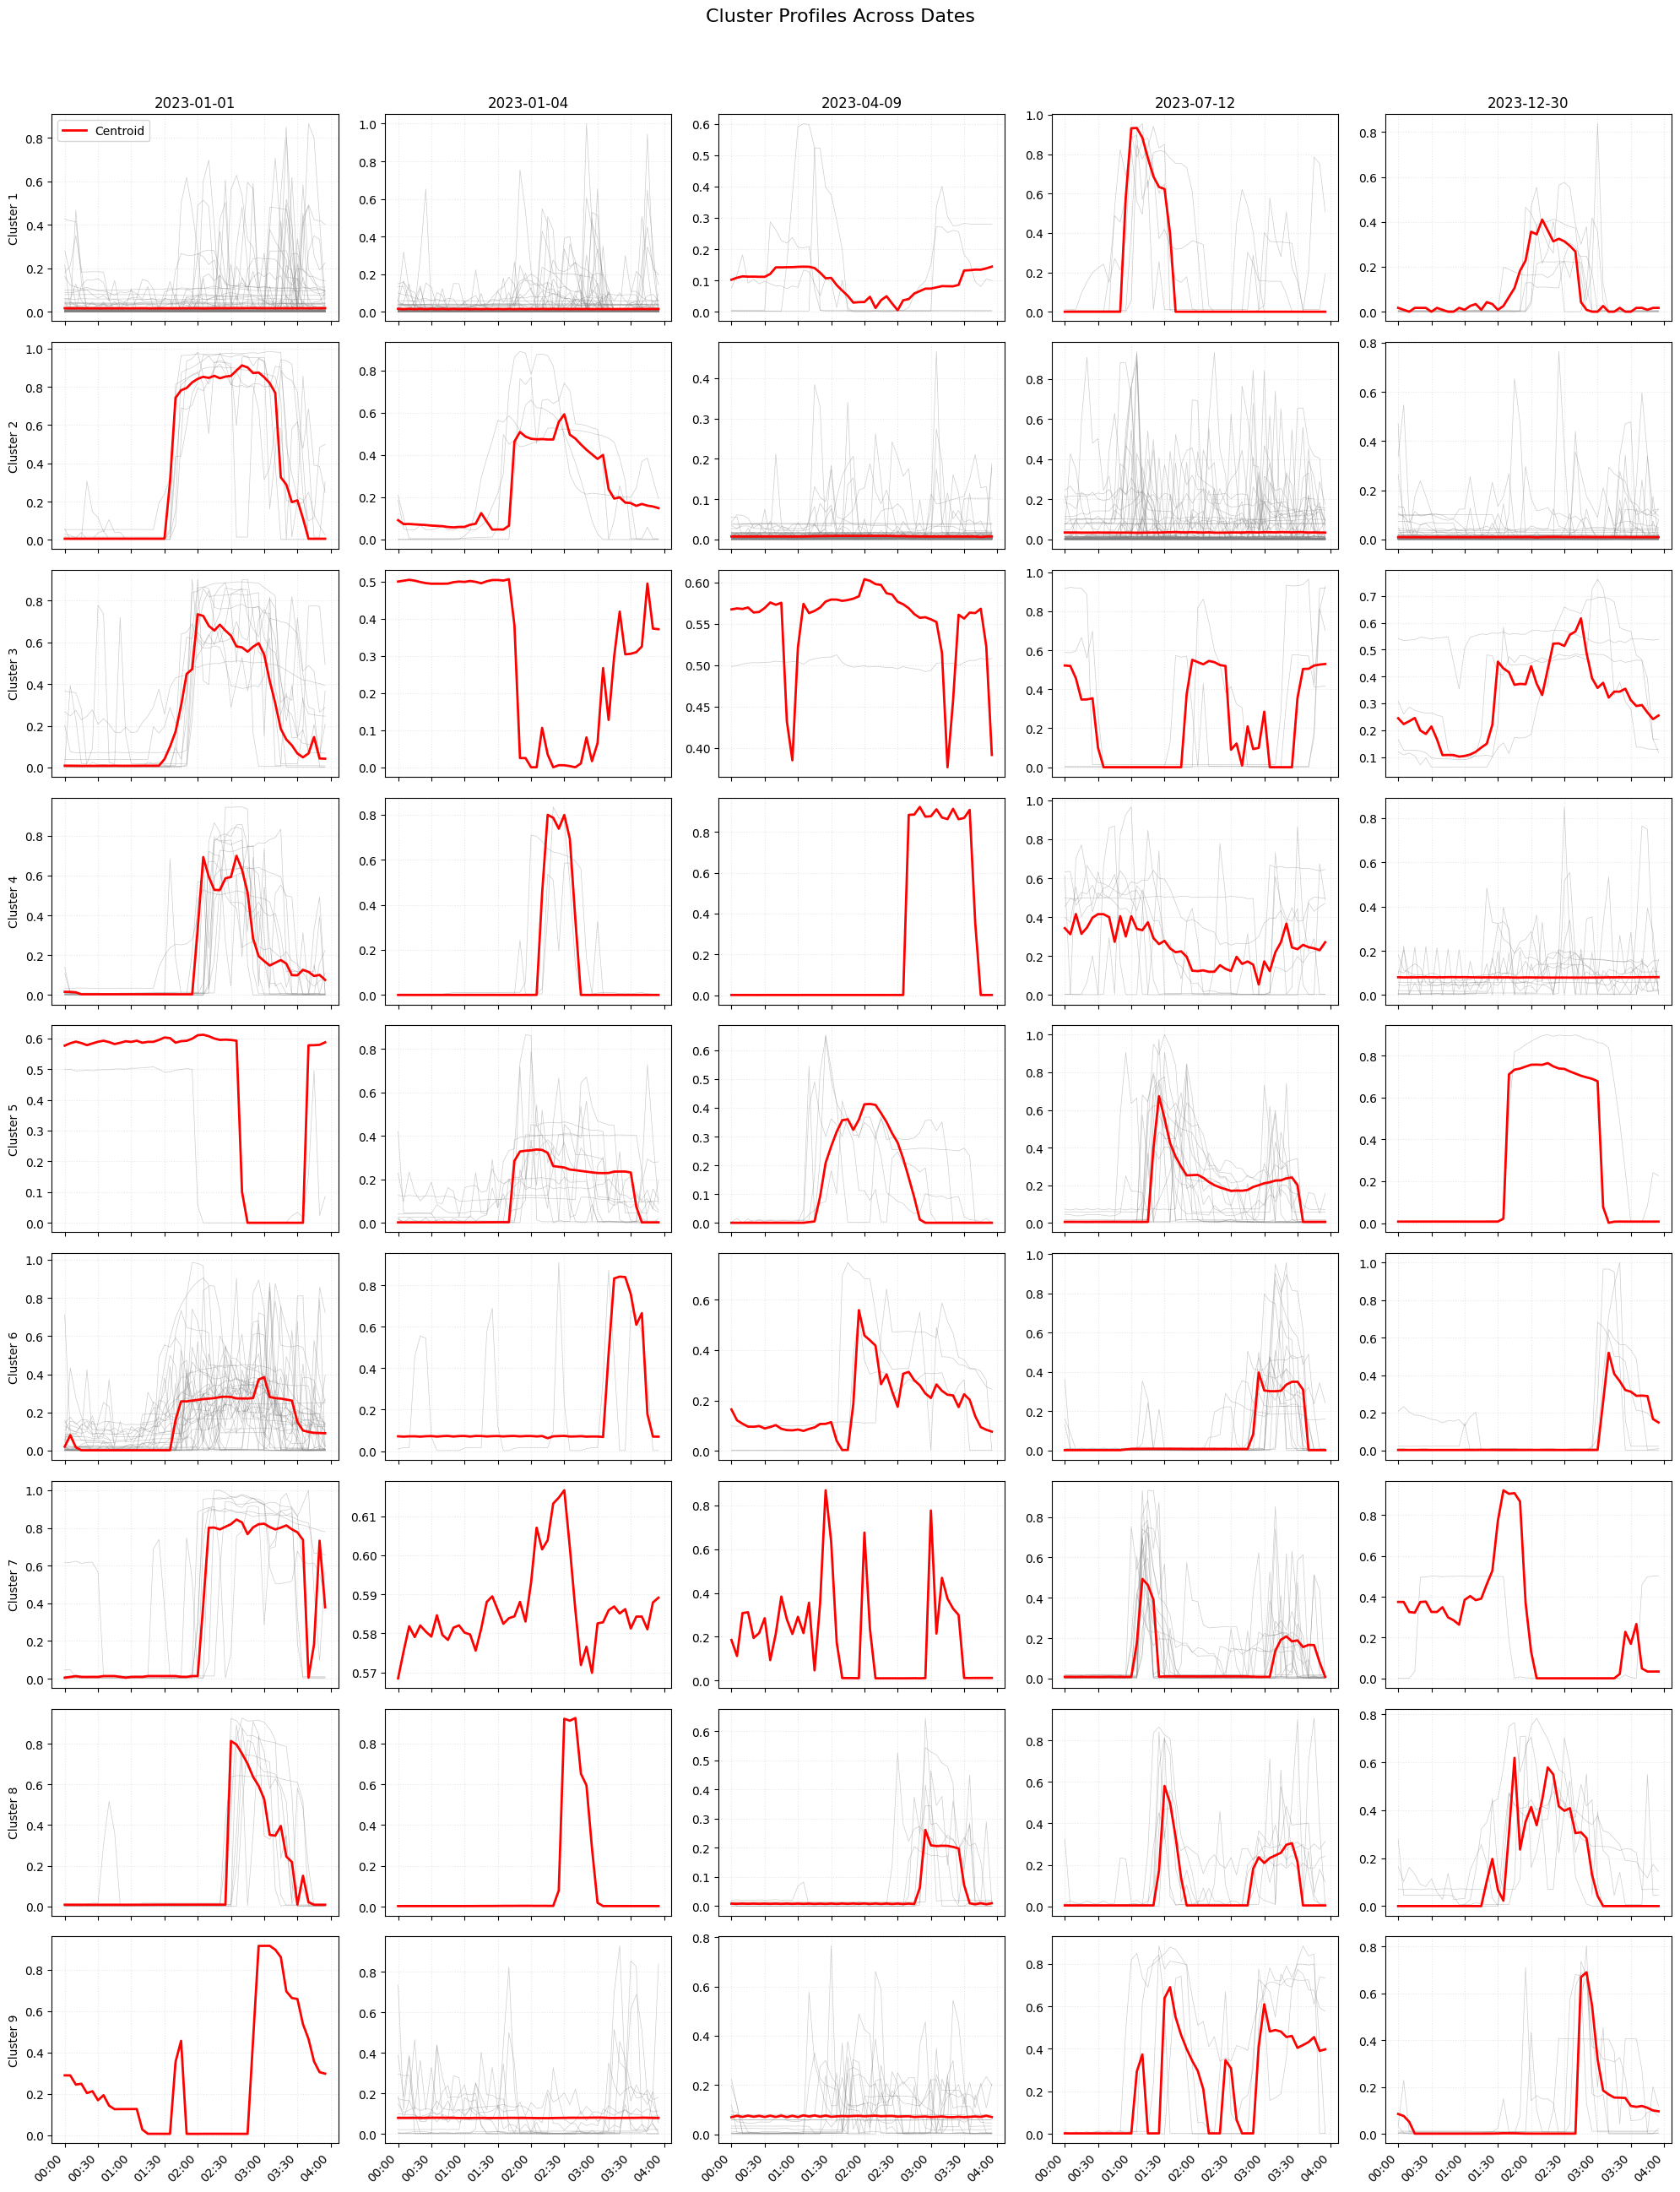

In [29]:

importlib.reload(cluster_grid)
selected_dates = ['2023-01-01', '2023-01-04', '2023-04-09', '2023-07-12', '2023-12-30']

# Example usage:
fig, axes = cluster_grid.visualize_cluster_grid(rlp_dict, cluster_sites_df, combined_df, num_clusters, selected_dates)
plt.show()

In [30]:
importlib.reload(cluster_grid)
rlp_aggregated = cluster_grid.aggregate_rlps(rlp_dict)

#Profile_Classes = cluster_grid.create_profile_classes_mean(rlp_aggregated, 9)

In [31]:
# finding the best number of profile classes

importlib.reload(clustering_processing2)
from clustering_processing2 import print_cluster_comparison_report, compare_cluster_sizes, evaluate_clustering_kmeans, mean_index_adequacy, aggregate_rlps, visualize_profile_classes, evaluate_clustering_dtw, evaluate_clustering_kmedoids, evaluate_clustering_kmeans_constrained

cluster_type = "kmeans_constrained"
min_clusters = 8
max_clusters = 10
cluster_results, best_clusters, Profile_Classes = compare_cluster_sizes(rlp_dict, cluster_type, min_clusters, max_clusters, save_plots=False, plot_dir=None, size_max = None)
print_cluster_comparison_report(cluster_results, best_clusters)


=== Cluster Comparison Report ===

Metrics Summary:
--------------------------------------------------
    Silhouette Score  Davies-Bouldin Index  Mean Index Adequacy  Combined Index  Silhouette Rank  Davies-Bouldin Rank  MIA Rank  Combined Index Rank
8             0.2664                1.5352               1.1830          6.8174              1.0                  1.0       3.0                  1.0
9             0.2264                1.5475               1.1557          7.9009              2.0                  2.0       1.0                  2.0
10            0.2226                1.6650               1.1569          8.6519              3.0                  3.0       2.0                  3.0

Optimal Number of Clusters by Metric:
--------------------------------------------------
Silhouette Score: 8 clusters
Score: 0.2664
Davies-Bouldin Index: 8 clusters
Score: 1.5352
Mean Index Adequacy: 9 clusters
Score: 1.1557
Combined Index: 8 clusters
Score: 6.8174


(<Figure size 1200x600 with 1 Axes>,
 <Axes: xlabel='Time of the Day', ylabel='Load'>)

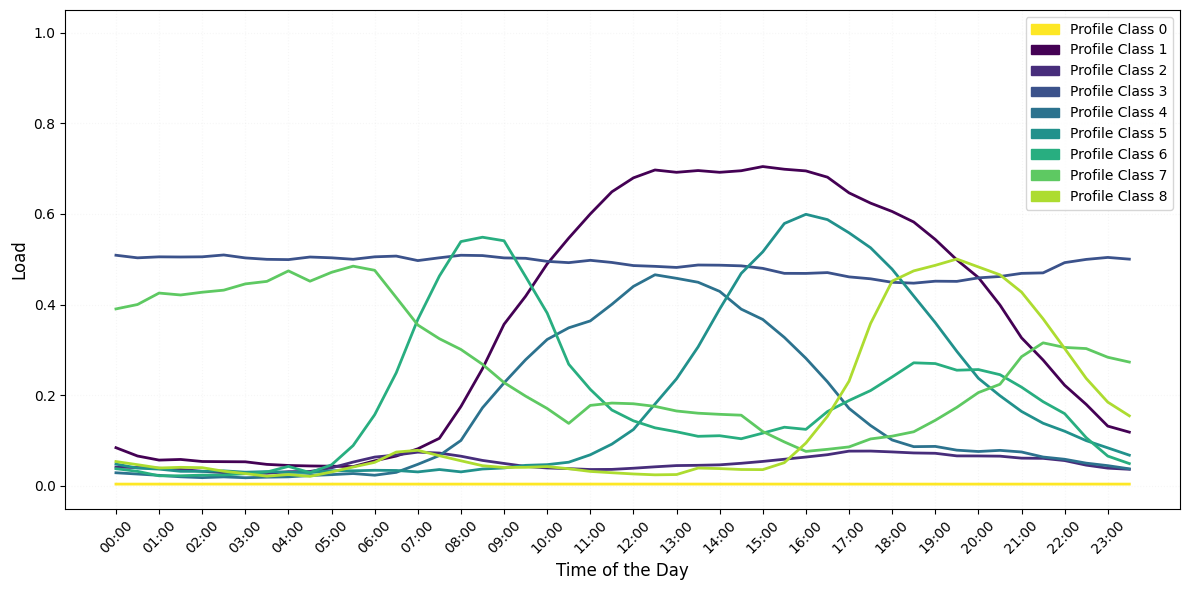

In [18]:
importlib.reload(clustering_processing2)
clustering_processing2.visualize_profile_classes(rlp_aggregated, Profile_Classes, 8)


Profile Class Sizes:
-------------------
Profile Class 0.0: 365 members
Profile Class 1.0: 265 members
Profile Class 2.0: 301 members
Profile Class 3.0: 424 members
Profile Class 4.0: 1284 members
Profile Class 5.0: 236 members
Profile Class 6.0: 221 members
Profile Class 7.0: 266 members
Profile Class 8.0: 288 members


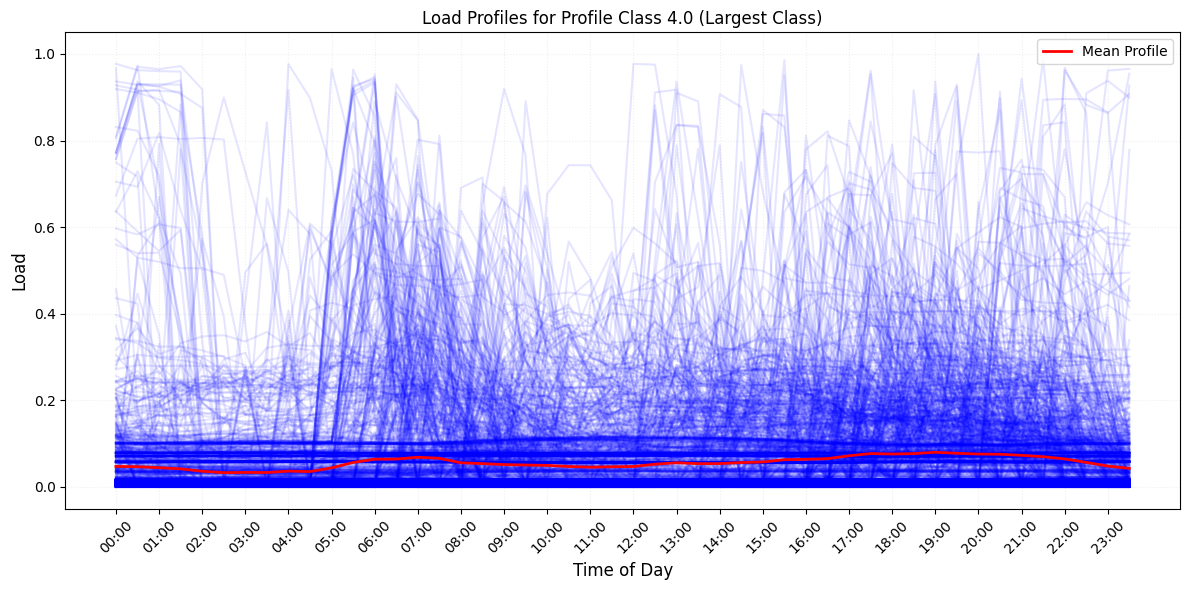

In [25]:
# Usage example:
importlib.reload(clustering_processing2)
class_sizes, fig = clustering_processing2.analyze_profile_classes(rlp_aggregated, Profile_Classes)
plt.show()

In [21]:
# Merging profile classes and cluster sites dataframes to get final assignments for each site on each day 
Profile_Classes.index.name = 'Date_Cluster' # set index name to match clusters 
date_range = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')

# Merge the two dataframes
merged_df = pd.merge(cluster_sites_df, Profile_Classes.reset_index(), on='Date_Cluster')


# Function to extract date from Date_Cluster
def extract_date(date_cluster):
    return pd.to_datetime(date_cluster.split('_')[0]).date()

merged_df['Date'] = merged_df['Date_Cluster'].apply(extract_date)

merged_df = merged_df.drop(columns = 'Date_Cluster')

# Create the final dataframe
final_df = pd.pivot_table(merged_df, values='Profile_Class', index='Date', columns='site_ID', aggfunc='first')
# Reindex with the full date range
final_df = final_df.reindex(date_range)

for i in final_df.columns:      
    final_df[[i]] = final_df[[i]].astype('Int64')
    
final_df.to_csv(os.path.join(base_directory, 'profile_class_assignments.csv'), index=True)


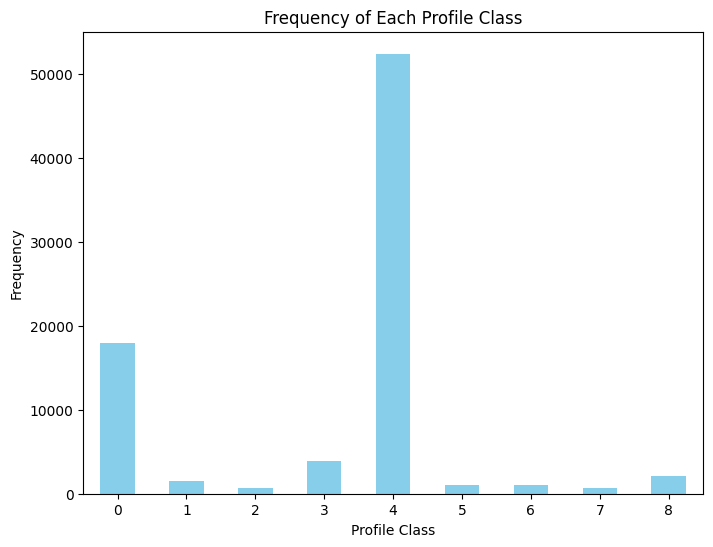

In [15]:
# Create figure of how many observations belong in each profile class 
frequency_counts = final_df.values.flatten()

# Count the occurrences of each number (cluster label)
counts = pd.Series(frequency_counts).value_counts()

# Plot the frequency of each number
plt.figure(figsize=(8, 6))
counts.sort_index().plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Profile Class')
plt.ylabel('Frequency')
plt.title('Frequency of Each Profile Class')
plt.xticks(rotation=0)
plt.show()

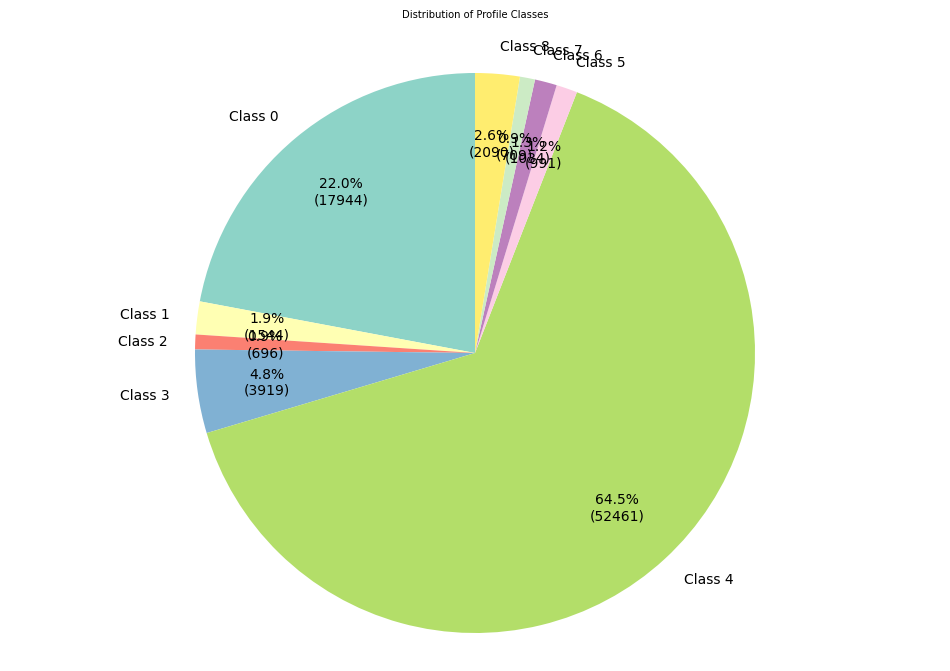

In [16]:
plt.figure(figsize=(12, 8))  # Made figure slightly wider

# Create pie chart with more spacing between labels
plt.pie(counts.sort_index(), 
        labels=[f'Class {i}' for i in counts.sort_index().index],
        autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(counts))})',  # Show both percentage and count on separate lines
        colors=plt.cm.Set3(np.linspace(0, 1, len(counts))),
        startangle=90,
        labeldistance=1.1,    # Move class labels further out
        pctdistance=0.75,     # Move percentage labels closer to center
        radius=0.8)           # Make pie slightly smaller to allow more room for labels

plt.rc('font', size=6)
plt.title('Distribution of Profile Classes', pad=20)  # Add padding to title
plt.axis('equal')
plt.show()

In [22]:


def merge_site_weather_data(profile_df, survey_df, weather_folder_path):
    """
    Merges site profile data with survey information and weather data.
    Also checks for stations with incomplete data.
    
    Parameters:
    -----------
    profile_df : pandas DataFrame
        DataFrame with dates as index and site_IDs as columns containing Profile_Class
    survey_df : pandas DataFrame
        DataFrame with site_IDs as index and columns for site characteristics
    weather_folder_path : str
        Path to the folder containing weather station data files
        
    Returns:
    --------
    tuple: (pandas DataFrame, dict)
        - DataFrame: Merged dataset with all required information
        - dict: Dictionary with station numbers as keys and number of missing days as values
    """
    # Step 1: Reshape profile_df to long format
    profile_long = profile_df.reset_index().melt(
        id_vars=['index'],
        var_name='site_ID',
        value_name='profile_class'
    ).rename(columns={'index': 'date'})

    survey_df['site_ID'] = survey_df['site_ID'].astype('str')
    profile_long['site_ID'] = profile_long['site_ID'].astype('str')

    # Step 2: Merge with survey data
    merged_df = pd.merge(
        profile_long,
        survey_df[['site_ID', 'climate_zone', 'aircon_type_simplified', 'property_construction', 'weather_station_number', 'num_bedrooms', 'num_occupants']],
        on='site_ID', how='left'
    )
    
    merged_df['weather_station_number'] = merged_df['weather_station_number'].astype('Int64')
    merged_df['date'] = pd.to_datetime(merged_df['date'])
    merged_df.to_csv('merged_df.csv')
    
    # Create an empty DataFrame to store all weather data
    all_weather_data = pd.DataFrame()
    
    # Dictionary to store stations with incomplete data
    incomplete_stations = {}
    
    # Process each weather station
    for station_number in merged_df['weather_station_number'].unique():
        if pd.notna(station_number):
            filename = f'daily_max_min_station_{int(station_number)}.csv'
            filepath = os.path.join(weather_folder_path, filename)
            
            if os.path.exists(filepath):
                try:
                    # Load weather data
                    weather_df = pd.read_csv(filepath)
                    weather_df['date'] = pd.to_datetime(weather_df['date'])
                    weather_df = weather_df.drop(columns=['station_number','state','max_wet_bulb_temperature','min_wet_bulb_temperature'])
                    
                    # Generate a full range of dates for 2023
                    full_date_range = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
                
                    # Reindex the dataframe to ensure we have an entry for each day
                    weather_df = weather_df.set_index('date').reindex(full_date_range).rename_axis('date').reset_index()
                    
                    # Interpolate missing values in max and min air temperature columns
                    weather_df['max_air_temperature'] = weather_df['max_air_temperature'].interpolate(method='linear', limit_direction='both')
                    weather_df['min_air_temperature'] = weather_df['min_air_temperature'].interpolate(method='linear', limit_direction='both')
                    
                    # Check for missing days
                    days_count = len(weather_df)
                    if days_count < 365:
                        incomplete_stations[int(station_number)] = 365 - days_count
                    # Check for missing values in max and min air temperature
                    if weather_df['max_air_temperature'].isna().all() or weather_df['min_air_temperature'].isna().all():
                        incomplete_stations[int(station_number)] = 'all missing'
                    
                    
                    # Add station number to weather data
                    weather_df['weather_station_number'] = station_number
                    
                    
                    # Append to all_weather_data
                    all_weather_data = pd.concat([all_weather_data, weather_df], ignore_index=True)
                    
                except Exception as e:
                    print(f"Error processing station {station_number}: {str(e)}")
                    raise
            else:
                print(f"Warning: File not found for station {station_number}: {filepath}")
                incomplete_stations[int(station_number)] = 365  # Mark as completely missing
    
    # Merge all weather data with main DataFrame
    final_df = pd.merge(
        merged_df,
        all_weather_data,
        on=['date', 'weather_station_number'],
        how='left'
    )
    
    # Remove rows where profile_class is missing
    final_df = final_df.dropna(subset=['profile_class'])
    
    # Ensure columns are in desired order
    column_order = [
        'date', 'site_ID', 'profile_class', 'climate_zone', 
        'aircon_type_simplified', 'property_construction', 'weather_station_number', 'num_bedrooms', 'num_occupants',
        'max_air_temperature', 'min_air_temperature'
    ]
    
    # Only select columns that exist in the DataFrame
    existing_columns = [col for col in column_order if col in final_df.columns]
    final_df = final_df[existing_columns]
    
    # Convert temperature columns to float
    final_df['max_air_temperature'] = pd.to_numeric(final_df['max_air_temperature'], errors='coerce')
    final_df['min_air_temperature'] = pd.to_numeric(final_df['min_air_temperature'], errors='coerce')
    
    print("\nFinal DataFrame Info:")
    print(f"Shape: {final_df.shape}")
    print("Missing temperature values:")
    print("Max temperature:", final_df['max_air_temperature'].isna().sum())
    print("Min temperature:", final_df['min_air_temperature'].isna().sum())
    
    if incomplete_stations:
        print("\nStations with incomplete data:")
        for station, missing_days in incomplete_stations.items():
            print(f"Station {station}: Missing {missing_days} days")
    
    return final_df, incomplete_stations


survey_df = pd.read_csv(os.path.join(base_directory, 'survey/survey_with_station.csv'))  # Change this to your output directory
survey_df.rename(columns={'edp_site_id': 'site_ID'}, inplace=True)

weather_folder_path = os.path.join(base_directory, 'weather/bom_data_max_min')  # Change this to your output directory
# Run the merger
result_df, incomplete_stations = merge_site_weather_data(final_df, survey_df, weather_folder_path)

print(incomplete_stations)

# if it doesn't exist already, export to csv

csv_path = 'df_for_regression_unconverted.csv'
if not os.path.exists(csv_path):
    result_df.to_csv(csv_path)
    print(f'File written: {csv_path}')
else:
    print('File already exists!')




Final DataFrame Info:
Shape: (81392, 11)
Missing temperature values:
Max temperature: 0
Min temperature: 0
{}
File already exists!
